# Feature Extractor

In [1]:
import tensorflow as tf
tf.random.set_seed(221)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import cv2
import os

extract_feature = True

Resnet18

In [2]:
if extract_feature:
    import timm

    model = timm.create_model(
        'resnet50.a1_in1k',
        pretrained=True,
        num_classes=0,  # remove classifier nn.Linear
    )
    model = model.eval()

    # get model specific transforms (normalization, resize)
    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)


In [3]:
def load_images_from_nested_folders(base_path):
    images = []
    labels = []

    # Traverse the base directory
    for class_label in os.listdir(base_path):
        class_label_path = os.path.join(base_path, class_label)
        
        if os.path.isdir(class_label_path):
            for subclass_label in os.listdir(class_label_path):
                subclass_label_path = os.path.join(class_label_path, subclass_label)
                
                if os.path.isdir(subclass_label_path):
                    for image_name in os.listdir(subclass_label_path):
                        image_path = os.path.join(subclass_label_path, image_name)
                        
                        try:
                            # Open and load the image
                            with Image.open(image_path) as img:
                                images.append(img.copy())
                                # Combine class and subclass labels
                                labels.append(f"{class_label}/{subclass_label}")
                        except Exception as e:
                            print(f"Error loading image {image_path}: {e}")
    
    return images, labels


In [4]:
# train
base_path = 'E:/Work/DS/Datasets/Raw/Industrial/SDNET2018 - Concrete Crack'
images, labels = load_images_from_nested_folders(base_path)

# Print the number of images loaded and their corresponding labels
print(f"Number of images loaded: {len(images)}")
print(f"Number of labels images loaded: {len(labels)}")

Number of images loaded: 56092
Number of labels images loaded: 56092


Test print image

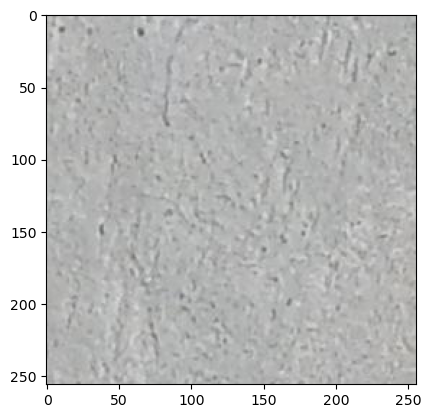

In [5]:
if extract_feature:
    img = images[0]
    
    plt.imshow(img)
    plt.show()

Process images from the cifar10 for the unwrapper

In [6]:
def process_minibatch(minibatch):
    batch_data = []
    for img in minibatch:
        # transform to model format and stack
        img = transforms(img)
        batch_data.append(img)
    batch_data = torch.stack(batch_data)
    # run through the resnet
    processed_data = model(batch_data)
    return processed_data

In [7]:
def feature_extraction(images,labels, is_train = False):

    output_df = pd.DataFrame(columns=['Class'])

    MINIBATCH_SIZE = 148

    # Convert the list of images to a batch tensor
    if is_train:
        NUMBER_MINIBATCH = 56092/MINIBATCH_SIZE
    else:
        NUMBER_MINIBATCH = 56092/MINIBATCH_SIZE
    for i in range(0,int(NUMBER_MINIBATCH)):
        print('processing minibatch %d out of %d' %(i+1 , int(NUMBER_MINIBATCH)))
        minibatch = images[i*MINIBATCH_SIZE:(i+1)*MINIBATCH_SIZE]

        # get features and put into df format
        minibatch_output = process_minibatch(minibatch)
        minibatch_output_df = pd.DataFrame(minibatch_output.detach().numpy(), columns=[f'features_{i}' for i in range(2048)])
        minibatch_output_df['Class'] = labels[i*MINIBATCH_SIZE:(i+1)*MINIBATCH_SIZE]

        output_df = pd.concat([output_df, minibatch_output_df], ignore_index=True)
    return output_df

In [8]:
import pandas as pd
if extract_feature:
    train = feature_extraction(images,labels, is_train = True)
    train.to_csv('extracted_features.csv', index = False)
else:
    train = pd.read_csv('extracted_features.csv')


processing minibatch 1 out of 379
processing minibatch 2 out of 379
processing minibatch 3 out of 379
processing minibatch 4 out of 379
processing minibatch 5 out of 379
processing minibatch 6 out of 379
processing minibatch 7 out of 379
processing minibatch 8 out of 379
processing minibatch 9 out of 379
processing minibatch 10 out of 379
processing minibatch 11 out of 379
processing minibatch 12 out of 379
processing minibatch 13 out of 379
processing minibatch 14 out of 379
processing minibatch 15 out of 379
processing minibatch 16 out of 379
processing minibatch 17 out of 379
processing minibatch 18 out of 379
processing minibatch 19 out of 379
processing minibatch 20 out of 379
processing minibatch 21 out of 379
processing minibatch 22 out of 379
processing minibatch 23 out of 379
processing minibatch 24 out of 379
processing minibatch 25 out of 379
processing minibatch 26 out of 379
processing minibatch 27 out of 379
processing minibatch 28 out of 379
processing minibatch 29 out o

In [9]:
print(train.head())
print(train.shape)

  Class  features_0  features_1  features_2  features_3  features_4  \
0  D/CD    0.007689         0.0    0.000228    0.000000    0.001742   
1  D/CD    0.008787         0.0    0.000000    0.016175    0.000563   
2  D/CD    0.007899         0.0    0.000000    0.002587    0.000439   
3  D/CD    0.000000         0.0    0.000000    0.000000    0.000000   
4  D/CD    0.004632         0.0    0.002906    0.000000    0.000000   

   features_5  features_6  features_7  features_8  ...  features_2038  \
0         0.0         0.0    0.054382         0.0  ...            0.0   
1         0.0         0.0    0.103560         0.0  ...            0.0   
2         0.0         0.0    0.234989         0.0  ...            0.0   
3         0.0         0.0    0.225073         0.0  ...            0.0   
4         0.0         0.0    0.124916         0.0  ...            0.0   

   features_2039  features_2040  features_2041  features_2042  features_2043  \
0            0.0            0.0            0.0        

Do the same for test set